In [ ]:
import os
import sys
import pathlib

import joblib
from joblib import load
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add utils directory to path
script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))

from data_loader import load_train_test_data, load_model_data
from model_utils import extract_weights

In [ ]:
def compute_cka(X, Y):
    """
    Computes the centered kernel alignment (CKA) similarity between two feature matrices X and Y.
    X and Y should have the same number of samples (rows).

    The feature matrices are weight matrices for two models. This can be multiple initializations of the same model for the VAEs, or two different model types.
    """
    # Drop non-numeric columns (like 'genes') if they exist
    if 'genes' in X.columns:
        X = X.drop(columns=['genes'])
    if 'genes' in Y.columns:
        Y = Y.drop(columns=['genes'])
    
    # Convert to numpy for matrix operations
    X = X.values
    Y = Y.values
    
    # Compute Gram matrices
    K = X @ X.T
    L = Y @ Y.T
    
    # Center the Gram matrices
    K_centered = K - K.mean(axis=0, keepdims=True) - K.mean(axis=1, keepdims=True) + K.mean()
    L_centered = L - L.mean(axis=0, keepdims=True) - L.mean(axis=1, keepdims=True) + L.mean()
    
    # Compute the numerator and denominator
    numerator = np.trace(K_centered @ L_centered)
    denominator = np.sqrt(np.trace(K_centered @ K_centered) * np.trace(L_centered @ L_centered))
    
    return numerator / denominator

In [3]:
def load_model(model_path):
    return load(model_path)

# Helper function to parse the filename
def parse_filename(model_file):
    """
    Parses the filename to extract metadata.
    Expected format: ModelName_latent_dims_X_trial_Y_init_Z_seed_W.joblib
    Example: betatcvae_latent_dims_6_trial_48_init_2_seed_1999415996.joblib
    """
    filename = pathlib.Path(os.path.basename(model_file))
    try:
        parts = filename.stem.split("_")
        model_name = parts[0]  # 'betatcvae'
        latent_dim = int(parts[3])  # Extract latent dimensions (6 in the example)
        trial = parts[5]  # Trial number (48 in the example)
        init = int(parts[7])  # Initialization number (2 in the example)
        seed = int(parts[9])  # Seed value (1999415996 in the example)
        return model_name, latent_dim, trial, init, seed
    except (IndexError, ValueError) as e:
        raise ValueError(f"Filename format unexpected: {filename}")

In [4]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()

train_df, test_df, val_df, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)
train_data = pd.DataFrame(train_df)

dependency_file = pathlib.Path(f"{data_directory}/CRISPRGeneEffect.parquet").resolve()
gene_dict_file = pathlib.Path(f"{data_directory}/CRISPR_gene_dictionary.parquet").resolve()
dependency_df, gene_dict_df= load_model_data(dependency_file, gene_dict_file)
gene_dict_df = pd.DataFrame(gene_dict_df)

(1150, 18444)


In [5]:
#Load weight data for VAEs
data_directory = pathlib.Path("../0.data-download/data").resolve()
weight_df = load_train_test_data(
    data_directory, train_or_test="train"
)

gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

weight_data = weight_df.filter(gene_list_passed_qc, axis=1)
weight_data.head()

,SDHA (6389),ALG6 (29929),CRTC2 (200186),MYO9B (4650),HNRNPH1 (3187),ATG101 (60673),SUCO (51430),TRNAU1AP (54952),RBX1 (9978),MON2 (23041),...,ELP3 (55140),CDIN1 (84529),KDM8 (79831),RNMT (8731),UBE2S (27338),CSE1L (1434),MTRR (4552),CEP55 (55165),RAB1A (5861),TMOD3 (29766)
0,0.017979,-0.289572,-0.222028,-0.351177,-1.125297,0.027765,0.136683,-0.335344,-1.165016,-0.168931,...,-1.131705,-0.604941,-1.037938,-1.275458,-0.253358,-2.344576,-0.045815,-0.902389,-0.420551,-0.006062
1,-0.237629,-0.158879,-0.277003,-0.276469,-1.080795,-0.340942,-0.010831,-0.319605,-1.481244,-0.129025,...,-0.836625,-0.409738,-0.615472,-0.968483,-0.474631,-2.164944,-0.062911,-0.229833,-0.296365,-0.061519
2,-0.111138,-0.144118,0.008695,-0.158184,-1.500071,-0.019999,-0.155866,-0.069393,-1.588956,-0.574180,...,-0.662457,-0.596762,-0.418323,-0.945636,-0.264785,-1.746390,-0.192415,-0.484720,-0.450508,-0.167877
3,-0.311599,-0.362584,-0.045986,-0.087613,-1.097254,-0.047637,-0.136866,-0.201854,-2.292119,-0.188254,...,-0.979437,-0.539253,-0.515660,-1.219806,-0.254612,-2.489566,0.065383,-0.232495,-0.596108,0.015531
4,-0.271563,-0.199930,-0.069537,-0.107372,-1.885115,0.001376,0.128589,-0.358348,-1.293549,-0.005660,...,-0.918393,-0.280643,-0.517168,-1.286654,-0.375986,-2.138105,-0.045446,-0.240697,-0.279726,-0.208687


In [6]:
# Directory where saved models are stored
model_save_dir = pathlib.Path("saved_models")

# Initialize a list to store CKA results
cka_results = []

# Gather all saved models
model_files = list(model_save_dir.glob("*.joblib"))

# Group models by (model_name, latent_dim) and initialization
model_groups = {}
for model_file in model_files:
    try:
        model_name, latent_dim, trial, init, seed = parse_filename(model_file)
        key = (model_name, latent_dim)
        if key not in model_groups:
            model_groups[key] = []
        model_groups[key].append({
            "file": model_file,
            "init": int(init),  # Ensure init is numeric for sorting
            "trial": trial,
            "seed": seed
        })
    except ValueError as e:
        print(e)
        continue

# Models that support multiple initializations
models_with_initializations = ["betavae", "betatcvae", "vanillavae"]

In [7]:
# Compare within model (average across initializations)
for (model_name, latent_dim), models in model_groups.items():
    if model_name not in models_with_initializations:
        continue  # Skip PCA, ICA, and NMF for within-initialization comparisons
    
    print(f"Comparing initializations for model {model_name} at latent_dim {latent_dim}")
    
    # Sort models by initialization for consistency
    models = sorted(models, key=lambda x: x["init"])
    
    cka_scores = []
    for i in range(len(models)):
        for j in range(i + 1, len(models)):  # Avoid duplicate pairs
            try:
                # Load models
                model_1 = joblib.load(models[i]["file"])
                model_2 = joblib.load(models[j]["file"])

                # Extract weight matrices
                weight_matrix_1 = extract_weights(model_1, model_name, weight_data)
                weight_matrix_2 = extract_weights(model_2, model_name, weight_data)

                # Compute CKA
                cka_score = compute_cka(weight_matrix_1, weight_matrix_2)
                cka_scores.append(cka_score)
            except Exception as e:
                print(f"Failed to compute CKA: {e}")
                continue

    # Average CKA scores across initializations
    if cka_scores:
        avg_cka = sum(cka_scores) / len(cka_scores)
        print(f"Average CKA for {model_name} at latent_dim {latent_dim}: {avg_cka}")
        cka_results.append({
            "comparison_type": "within_model_init",
            "model_name": model_name,
            "latent_dim": latent_dim,
            "average_cka": avg_cka
        })

In [8]:
# Compare across models for the same latent dimension (averaging over initializations)
unique_latent_dims = set(latent_dim for _, latent_dim in model_groups.keys())

for latent_dim in unique_latent_dims:
    print(f"Comparing across models for latent_dim {latent_dim}")
    
    models_for_dim = [
        (model_name, models) for (model_name, dim), models in model_groups.items() if dim == latent_dim
    ]
    
    for i in range(len(models_for_dim)):
        for j in range(i + 1, len(models_for_dim)):
            model_name_1, models_1 = models_for_dim[i]
            model_name_2, models_2 = models_for_dim[j]

            cka_scores = []
            try:
                # Compare initializations 1-5 for both models
                for init_1 in models_1:
                    for init_2 in models_2:
                        if init_1["init"] <= 5 and init_2["init"] <= 5:
                            # Load models
                            model_1 = joblib.load(init_1["file"])
                            model_2 = joblib.load(init_2["file"])

                            # Extract weight matrices
                            weight_matrix_1 = extract_weights(model_1, model_name_1, weight_data, dependency_df)
                            weight_matrix_2 = extract_weights(model_2, model_name_2, weight_data, dependency_df)

                            # Compute CKA
                            cka_score = compute_cka(weight_matrix_1, weight_matrix_2)
                            cka_scores.append(cka_score)
            except Exception as e:
                print(f"Failed to compute CKA: {e}")
                continue

            # Average CKA scores across initializations
            if cka_scores:
                avg_cka = sum(cka_scores) / len(cka_scores)
                print(f"Average CKA between {model_name_1} and {model_name_2} at latent_dim {latent_dim}: {avg_cka}")
                cka_results.append({
                    "comparison_type": "across_models",
                    "latent_dim": latent_dim,
                    "model_1": model_name_1,
                    "model_2": model_name_2,
                    "average_cka": avg_cka
                })


In [9]:
# Save CKA results to a CSV
cka_results_df = pd.DataFrame(cka_results)
cka_results_df.to_csv("cka_results.csv", index=False)
print("CKA results saved to cka_results.csv")

CKA results saved to cka_results.csv


In [ ]:
# Filter for within-model initialization scores
within_model_df = cka_results_df[cka_results_df['comparison_type'] == 'within_model_init']

# Convert latent_dim to a categorical type for equal spacing
within_model_df['latent_dim'] = within_model_df['latent_dim'].astype(str)

# Convert latent_dim to ordered categories for within_model_df
dimension_order = sorted(within_model_df["latent_dim"].unique(), key=int)
within_model_df["latent_dim"] = pd.Categorical(
    within_model_df["latent_dim"], categories=dimension_order, ordered=True
)


# Plot for each model
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=within_model_df, 
    x="latent_dim",  # Treated as categorical
    y="average_cka", 
    hue="model_name", 
    marker="o", 
    linewidth=2
)
plt.title("Initialization Scores Across Latent Dimensions for Each Model (Scaled Equally)")
plt.xlabel("Latent Dimensions")
plt.ylabel("Average CKA Score")
plt.legend(title="Model Name")

# save the figure
init_save_path = pathlib.Path("../4.gene-expression-signatures/figures/initializations.png")
plt.savefig(init_save_path, bbox_inches="tight", dpi=600)

/tmp/ipykernel_27191/3571781231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  across_models_df['model_pair'] = across_models_df['model_1'] + " vs " + across_models_df['model_2']
/tmp/ipykernel_27191/3571781231.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  across_models_df['latent_dim'] = across_models_df['latent_dim'].astype(str)
/tmp/ipykernel_27191/3571781231.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

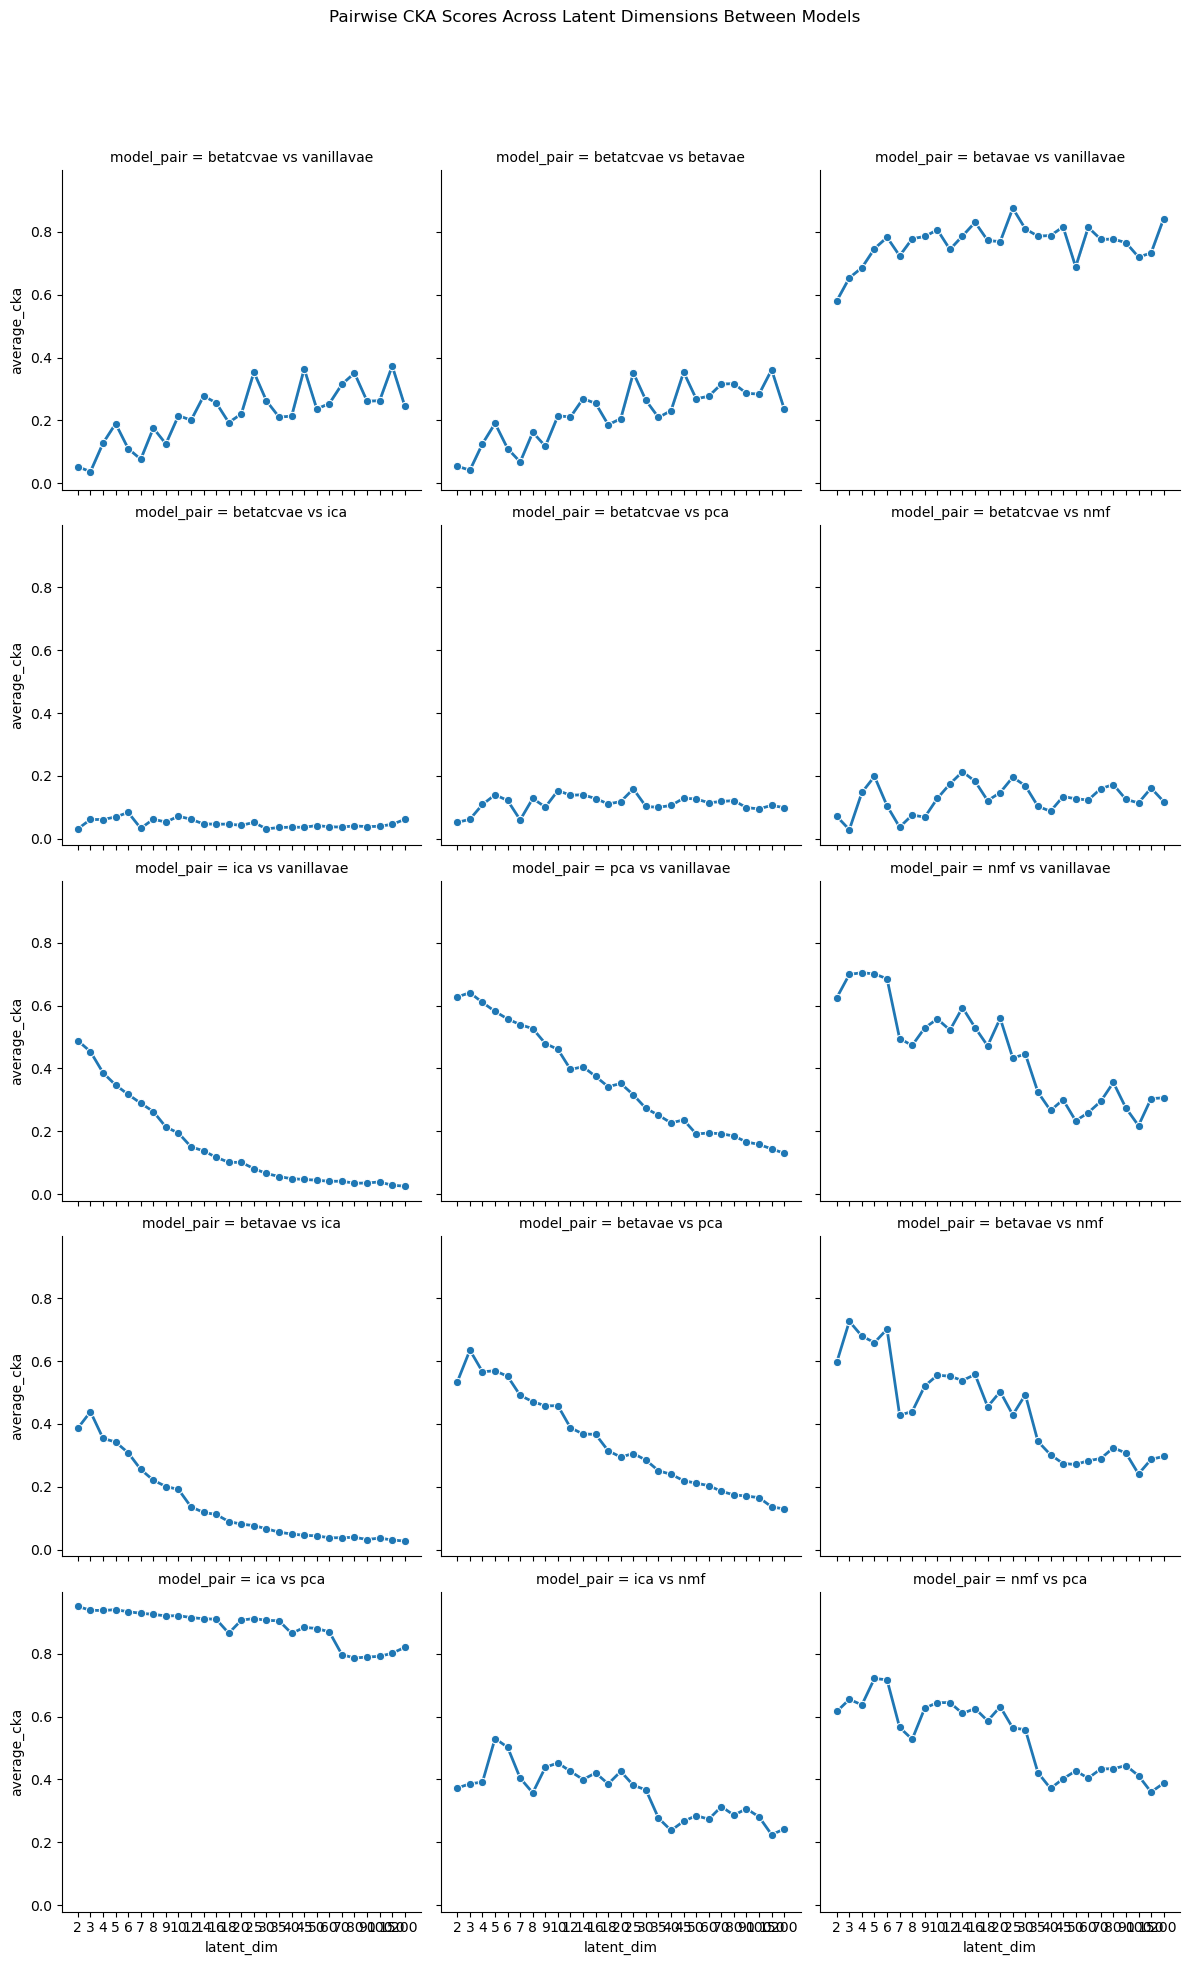

In [ ]:
# Filter for between-model scores
across_models_df = cka_results_df[cka_results_df['comparison_type'] == 'across_models']

# Create a new column to combine model pairs
across_models_df['model_pair'] = across_models_df['model_1'] + " vs " + across_models_df['model_2']

# Convert latent_dim to a categorical type for equal spacing
across_models_df['latent_dim'] = across_models_df['latent_dim'].astype(str)

# Convert latent_dim to ordered categories for across_models_df
dimension_order = sorted(across_models_df["latent_dim"].unique(), key=int)
across_models_df["latent_dim"] = pd.Categorical(
    across_models_df["latent_dim"], categories=dimension_order, ordered=True
)

# Normalize model pairs to prevent duplicates
across_models_df['model_pair'] = across_models_df.apply(
    lambda row: ' vs '.join(sorted([row['model_1'], row['model_2']])), axis=1
)

# Initialize FacetGrid for across-model scores
g = sns.FacetGrid(across_models_df, col="model_pair", col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, "latent_dim", "average_cka", marker="o", linewidth=2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Pairwise CKA Scores Across Latent Dimensions Between Models")

# save the figure
models_save_path = pathlib.Path("../4.gene-expression-signatures/figures/modelCKA.png")
plt.savefig(models_save_path, bbox_inches="tight", dpi=600)